## Setup

### Install the TensorFlow Model Garden pip package

`tf-nightly` is the nightly Model Garden package created daily automatically. We install it with pip.

In [ ]:
!pip install --upgrade pip
!pip install tensorflow
!pip install tfds-nightly

     |████████████████████████████████| 2.1 MB 4.3 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.3/86.3 KB 10.2 MB/s eta 0:00:00


### Install the Sequence Projection Models package

Install Bazel: This will allow us to build custom TensorFlow ops used by the PRADO architecture.

In [ ]:
!sudo apt install curl gnupg
!curl https://bazel.build/bazel-release.pub.gpg | sudo apt-key add -
!echo "deb [arch=amd64] https://storage.googleapis.com/bazel-apt stable jdk1.8" | sudo tee /etc/apt/sources.list.d/bazel.list
!sudo apt update
!sudo apt install bazel

Reading package lists... Done
Building dependency tree       
Reading state information... Done
curl is already the newest version (7.58.0-2ubuntu3.16).
gnupg is already the newest version (2.2.4-1ubuntu1.4).
gnupg set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3199  100  3199    0     0  12644      0 --:--:-- --:--:-- --:--:-- 12594
OK
deb [arch=amd64] https://storage.googleapis.com/bazel-apt stable jdk1.8
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 https://storage.googleapis.com/bazel-apt stable InRelease [2,256 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/ma

Install the library:
* `seq_flow_lite` includes the PRADO architecture and custom ops.
* We download the code from GitHub, and then build and install the TF and TFLite ops used by the model.


In [ ]:
#only run if you're rerunning cells below
!rm -rf tensorflow/models
!rm -rf models

In [ ]:
!git clone https://www.github.com/tensorflow/models
!models/research/seq_flow_lite/demo/colab/setup_workspace.sh
!pip install models/research/seq_flow_lite
!rm -rf models/research/seq_flow_lite/tf_ops
!rm -rf models/research/seq_flow_lite/tflite_ops

Cloning into 'models'...
remote: Enumerating objects: 71858, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 71858 (delta 1), reused 12 (delta 1), pack-reused 71844
Receiving objects: 100% (71858/71858), 578.91 MiB | 11.76 MiB/s, done.
Resolving deltas: 100% (50825/50825), done.
Processing ./models/research/seq_flow_lite
  Preparing metadata (setup.py) ... done
  Created wheel for seq-flow-lite: filename=seq_flow_lite-0.1-py3-none-any.whl size=772854 sha256=f8034805d9e604a6270630412794fcd1a03ab274c9c542015a941278fcf91a76
  Stored in directory: /tmp/pip-ephem-wheel-cache-w1fb4ncm/wheels/26/bb/63/aa462b33ec699deb2e67d7ff95cf71cd0f2838dcf19f49f5d5
Successfully built seq-flow-lite


## Training an Emotion Prediction Model

* First, we load the GoEmotions data from TFDS.
* Next, we prepare the PRADO model for training. We set up the model configuration, including hyperparameters and labels. We also prepare the dataset, which involves projecting the inputs from the dataset, and passing the projections to the model.  This is needed because a model training on TPU can not handle string inputs.
* Finally, we train and evaluate the model and produce model-level and per-label metrics.

***Start here on Runtime reset***, once the packages above are properly installed:
* Go to the `seq_flow_lite` directory.

In [ ]:
%cd models/research/seq_flow_lite

/content/models/research/seq_flow_lite


* Import the Tensorflow and Tensorflow Dataset libraries.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
import pandas as pd
import io

### The data: GoEmotions
In this tutorial, we use the [GoEmotions dataset from TFDS](https://www.tensorflow.org/datasets/catalog/goemotions).

GoEmotions is a corpus of comments extracted from Reddit, with human annotations to 27 emotion categories or Neutral.

*   Number of labels: 27.
*   Size of training dataset: 43,410.
*   Size of evaluation dataset: 5,427.
*   Maximum sequence length in training and evaluation datasets: 30.

The emotion categories are admiration, amusement, anger, annoyance, approval, caring, confusion, curiosity, desire, disappointment, disapproval, disgust, embarrassment, excitement, fear, gratitude, grief, joy, love, nervousness, optimism, pride, realization, relief, remorse, sadness, surprise.


Load the data from TFDS:

In [ ]:
LABELS = [
    'admiration',
    'amusement',
    'anger',
    'annoyance',
    'approval',
    'caring',
    'confusion',
    'curiosity',
    'desire',
    'disappointment',
    'disapproval',
    'disgust',
    'embarrassment',
    'excitement',
    'fear',
    'gratitude',
    'grief',
    'joy',
    'love',
    'nervousness',
    'optimism',
    'pride',
    'realization',
    'relief',
    'remorse',
    'sadness',
    'surprise',
    'neutral',
]

In [ ]:
#only run this if loading in the goemotions data
ds = tfds.load('goemotions', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/goemotions/0.1.0.incompleteTTADI1/goemotions-train.tfrecord


  0%|          | 0/43410 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/goemotions/0.1.0.incompleteTTADI1/goemotions-validation.tfrecord


  0%|          | 0/5426 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/goemotions/0.1.0.incompleteTTADI1/goemotions-test.tfrecord


  0%|          | 0/5427 [00:00<?, ? examples/s]

Dataset goemotions downloaded and prepared to /root/tensorflow_datasets/goemotions/0.1.0. Subsequent calls will reuse this data.


In [ ]:
assert isinstance(ds, tf.data.Dataset)

In [ ]:
print(ds)

<PrefetchDataset element_spec={'admiration': TensorSpec(shape=(), dtype=tf.bool, name=None), 'amusement': TensorSpec(shape=(), dtype=tf.bool, name=None), 'anger': TensorSpec(shape=(), dtype=tf.bool, name=None), 'annoyance': TensorSpec(shape=(), dtype=tf.bool, name=None), 'approval': TensorSpec(shape=(), dtype=tf.bool, name=None), 'caring': TensorSpec(shape=(), dtype=tf.bool, name=None), 'comment_text': TensorSpec(shape=(), dtype=tf.string, name=None), 'confusion': TensorSpec(shape=(), dtype=tf.bool, name=None), 'curiosity': TensorSpec(shape=(), dtype=tf.bool, name=None), 'desire': TensorSpec(shape=(), dtype=tf.bool, name=None), 'disappointment': TensorSpec(shape=(), dtype=tf.bool, name=None), 'disapproval': TensorSpec(shape=(), dtype=tf.bool, name=None), 'disgust': TensorSpec(shape=(), dtype=tf.bool, name=None), 'embarrassment': TensorSpec(shape=(), dtype=tf.bool, name=None), 'excitement': TensorSpec(shape=(), dtype=tf.bool, name=None), 'fear': TensorSpec(shape=(), dtype=tf.bool, name=

Load in Spotify data for later use

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sp_tr = pd.read_csv('/content/drive/MyDrive/266/strat_training.csv')
sp_test = pd.read_csv('/content/drive/MyDrive/266/strat_test.csv')
sp_dev = pd.read_csv('/content/drive/MyDrive/266/strat_val.csv')

In [ ]:
sp_train_new = sp_tr.drop(['tag_agreement', 'string', 'top_tag', ' bad_string', 'id'], axis=1)
sp_test_new = sp_test.drop(['tag_agreement', 'string', 'top_tag', ' bad_string', 'id'], axis=1)
sp_dev_new = sp_test.drop(['tag_agreement', 'string', 'top_tag', ' bad_string', 'id'], axis=1)

In [ ]:
sp_train_new = sp_train_new.rename(columns={" amusement": "amusement", " anger": "anger", " annoyance": "annoyance", " approval": "approval",
                       " caring": "caring", " confusion": "confusion", " curiosity": "curiosity", " desire":"desire", " disappointment":"disappointment",
                       " disapproval": "disapproval", " disgust": "disgust", " embarrassment":"embarrassment",
                       " excitement": "excitement", " fear": "fear", " gratitude": "gratitude", " grief": "grief", " joy": "joy",
                       " love": "love", " nervousness": "nervousness", " optimism": "optimism", " pride": "pride", " realization": "realization",
                       " relief": "relief", " sadness":"sadness", " surprise": "surprise"," neutral": "neutral"})
sp_test_new = sp_test_new.rename(columns={" amusement": "amusement", " anger": "anger", " annoyance": "annoyance", " approval": "approval",
                       " caring": "caring", " confusion": "confusion", " curiosity": "curiosity", " desire":"desire", " disappointment":"disappointment",
                       " disapproval": "disapproval", " disgust": "disgust", " embarrassment":"embarrassment",
                       " excitement": "excitement", " fear": "fear", " gratitude": "gratitude", " grief": "grief", " joy": "joy",
                       " love": "love", " nervousness": "nervousness", " optimism": "optimism", " pride": "pride", " realization": "realization",
                       " relief": "relief", " sadness":"sadness", " surprise": "surprise"," neutral": "neutral"})
sp_dev_new = sp_dev_new.rename(columns={" amusement": "amusement", " anger": "anger", " annoyance": "annoyance", " approval": "approval",
                       " caring": "caring", " confusion": "confusion", " curiosity": "curiosity", " desire":"desire", " disappointment":"disappointment",
                       " disapproval": "disapproval", " disgust": "disgust", " embarrassment":"embarrassment",
                       " excitement": "excitement", " fear": "fear", " gratitude": "gratitude", " grief": "grief", " joy": "joy",
                       " love": "love", " nervousness": "nervousness", " optimism": "optimism", " pride": "pride", " realization": "realization",
                       " relief": "relief", " sadness":"sadness", " surprise": "surprise"," neutral": "neutral"})

In [ ]:
for label in LABELS:
  sp_train_new[label] = sp_train_new[label].astype('bool')
  sp_test_new[label] = sp_test_new[label].astype('bool')
  sp_dev_new[label] = sp_dev_new[label].astype('bool')

In [ ]:
#sp_train = tf.data.Dataset.from_tensor_slices((sp_train_new['target_string'].values, sp_train_new.drop('target_string', axis=1).values))
#sp_test = tf.data.Dataset.from_tensor_slices((sp_test_new['target_string'].values, sp_test_new.drop('target_string', axis=1).values))
sp_train = tf.data.Dataset.from_tensor_slices(dict(sp_train_new))
sp_test = tf.data.Dataset.from_tensor_slices(dict(sp_test_new))
sp_dev = tf.data.Dataset.from_tensor_slices(dict(sp_dev_new))

In [ ]:
assert isinstance(sp_train, tf.data.Dataset)
assert isinstance(sp_test, tf.data.Dataset)
assert isinstance(sp_dev, tf.data.Dataset)

### The model: PRADO

We train an Emotion Prediction model, based on the [PRADO architecture](https://github.com/tensorflow/models/blob/master/research/seq_flow_lite/models/prado.py) from the [Sequence Projection Models package](https://github.com/tensorflow/models/tree/master/research/seq_flow_lite).

PRADO projects input sequences to fixed sized features. The idea behind this approach is to build embedding-free models that minimize the model size. Instead of using an embedding table to lookup embeddings, sequence projection models compute them on the fly, resulting in space-efficient models.

In this section, we prepare the PRADO model for training.

This GoEmotions dataset is not set up so that it can be directly fed into the PRADO model, so below, we also handle the necessary preprocessing by providing a dataset builder.

Prepare the model configuration:
* Enumerate the labels expected to be found in the GoEmotions dataset.
* Prepare the `MODEL_CONFIG` dictionary which includes training parameters for the model. See sample configs for the PRADO model [here](https://github.com/tensorflow/models/tree/master/research/seq_flow_lite/configs).

In [ ]:
# Model training parameters.
CONFIG = {
    'name': 'models.prado',
    'batch_size': 1024,
    'train_steps': 10000,
    'learning_rate': 0.0006,
    'learning_rate_decay_steps': 340,
    'learning_rate_decay_rate': 0.7,
}

# Limits the amount of logging output produced by the training run, in order to
# avoid browser slowdowns.
CONFIG['save_checkpoints_steps'] = int(CONFIG['train_steps'] / 10)

MODEL_CONFIG = {
    'labels': LABELS,
    'multilabel': True,
    'quantize': False,
    'max_seq_len': 128,
    'max_seq_len_inference': 128,
    'exclude_nonalphaspace_unicodes': False,
    'split_on_space': True,
    'embedding_regularizer_scale': 0.035,
    'embedding_size': 64,
    'bigram_channels': 64,
    'trigram_channels': 64,
    'feature_size': 512,
    'network_regularizer_scale': 0.0001,
    'keep_prob': 0.5,
    'word_novelty_bits': 0,
    'doc_size_levels': 0,
    'add_bos_tag': False,
    'add_eos_tag': False,
    'pre_logits_fc_layers': [],
    'text_distortion_probability': 0.0,
}

CONFIG['model_config'] = MODEL_CONFIG

Write a function that builds the datasets for the model.  It will load the data, handle batching, and generate projections for the input text.

In [ ]:
from layers import base_layers
from layers import projection_layers

def build_dataset(mode, inspect=False):
  if mode == base_layers.TRAIN:
    split = 'train'
    count = None
  elif mode == base_layers.EVAL:
    split = 'test'
    count = 1
  else:
    raise ValueError('mode={}, must be TRAIN or EVAL'.format(mode))

  batch_size = CONFIG['batch_size']
  if inspect:
    batch_size = 1

  # Convert examples from their dataset format into the model format.
  def process_input(features):
    # Generate the projection for each comment_text input.  The final tensor 
    # will have the shape [batch_size, number of tokens, feature size].
    # Additionally, we generate a tensor containing the number of tokens for
    # each comment_text (seq_length).  This is needed because the projection
    # tensor is a full tensor, and we are not using EOS tokens.
    text = features['comment_text']
    text = tf.reshape(text, [batch_size])
    projection_layer = projection_layers.ProjectionLayer(MODEL_CONFIG, mode)
    projection, seq_length = projection_layer(text)

    # Convert the labels into an indicator tensor, using the LABELS indices.
    label = tf.stack([features[label] for label in LABELS], axis=-1)
    label = tf.cast(label, tf.float32)
    label = tf.reshape(label, [batch_size, len(LABELS)])

    model_features = ({'projection': projection, 'sequence_length': seq_length}, label)

    if inspect:
      model_features = (model_features[0], model_features[1], features)

    return model_features

  ds = tfds.load('goemotions', split=split)
  ds = ds.repeat(count=count)
  ds = ds.shuffle(buffer_size=batch_size * 2)
  ds = ds.batch(batch_size, drop_remainder=True)
  ds = ds.map(process_input,
              num_parallel_calls=tf.data.experimental.AUTOTUNE,
              deterministic=False)
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

train_dataset = build_dataset(base_layers.TRAIN)
test_dataset = build_dataset(base_layers.EVAL)
inspect_dataset = build_dataset(base_layers.TRAIN, inspect=True)

### Train and Evaluate

First we define a function to build the model.  We vary the model inputs depending on task.  For training and evaluation, we'll take the projection and sequence length as inputs.  Otherwise, we'll take strings as inputs.

In [ ]:
from models import prado

def build_model(mode):
  # First we define our inputs.
  inputs = []
  if mode == base_layers.TRAIN or mode == base_layers.EVAL:
    # For TRAIN and EVAL, we'll be getting dataset examples,
    # so we'll get projections and sequence_lengths.
    projection = tf.keras.Input(
        shape=(MODEL_CONFIG['max_seq_len'], MODEL_CONFIG['feature_size']),
        name='projection',
        dtype='float32')

    sequence_length = tf.keras.Input(
        shape=(), name='sequence_length', dtype='float32')
    inputs = [projection, sequence_length]
  else:
    # Otherwise, we get string inputs which we need to project.
    input = tf.keras.Input(shape=(), name='input', dtype='string')
    projection_layer = projection_layers.ProjectionLayer(MODEL_CONFIG, mode)
    projection, sequence_length = projection_layer(input)
    inputs = [input]

  # Next we add the model layer.
  model_layer = prado.Encoder(MODEL_CONFIG, mode)
  logits = model_layer(projection, sequence_length)

  # Finally we add an activation layer.
  if MODEL_CONFIG['multilabel']:
    activation = tf.keras.layers.Activation('sigmoid', name='predictions')
  else:
    activation = tf.keras.layers.Activation('softmax', name='predictions')
  predictions = activation(logits)

  model = tf.keras.Model(
      inputs=inputs,
      outputs=[predictions])
  
  return model


Train the model:

Try to create callbacks using OS

In [ ]:
!ls '/content/drive/MyDrive/266/finetune_goemo'

checkpoint  fine_tune_best.data-00000-of-00001	fine_tune_best.index


In [ ]:
from keras.callbacks import ModelCheckpoint

Do not re-run the following two cells. Instead, load in the original model to evaluate

In [ ]:
# https://cv-tricks.com/tensorflow-tutorial/save-restore-tensorflow-models-quick-complete-tutorial/
checkpoint_filepath = '/content/drive/MyDrive/266/original_model/goemo_model'
model_checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_filepath, 
    save_weights_only=True,
    verbose = 1)

In [ ]:
from keras import backend as K
def custom_f1(y_true, y_pred):
  def recall_m(y_true, y_pred):
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
      recall = true_positives / (possible_positives + K.epsilon())
      return recall
  def precision_m(y_true, y_pred):
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
      precision = true_positives / (predicted_positives + K.epsilon())
      return precision
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Remove any previous training data.
!rm -rf model

model = build_model(base_layers.TRAIN)

# Create the optimizer.
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=CONFIG['learning_rate'],
    decay_rate=CONFIG['learning_rate_decay_rate'],
    decay_steps=CONFIG['learning_rate_decay_steps'],
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Define the loss function.
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

model.compile(optimizer=optimizer, loss=loss)

epochs = int(CONFIG['train_steps'] / CONFIG['save_checkpoints_steps'])
history = model.fit(
    x=train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    steps_per_epoch=CONFIG['save_checkpoints_steps'],
    callbacks=[model_checkpoint_callback])

Epoch 1/10
1000/1000 [==============================] - ETA: 0s - loss: 0.6065
Epoch 1: saving model to /content/drive/MyDrive/266/finetune_goemo/goemo_model
1000/1000 [==============================] - 161s 156ms/step - loss: 0.6065 - val_loss: 0.5201
Epoch 2/10
1000/1000 [==============================] - ETA: 0s - loss: 0.4885
Epoch 2: saving model to /content/drive/MyDrive/266/finetune_goemo/goemo_model
1000/1000 [==============================] - 155s 155ms/step - loss: 0.4885 - val_loss: 0.4682
Epoch 3/10
1000/1000 [==============================] - ETA: 0s - loss: 0.4560
Epoch 3: saving model to /content/drive/MyDrive/266/finetune_goemo/goemo_model
1000/1000 [==============================] - 155s 155ms/step - loss: 0.4560 - val_loss: 0.4518
Epoch 4/10
1000/1000 [==============================] - ETA: 0s - loss: 0.4449
Epoch 4: saving model to /content/drive/MyDrive/266/finetune_goemo/goemo_model
1000/1000 [==============================] - 153s 153ms/step - loss: 0.4449 - val_l

Plot loss vs. epochs

In [ ]:
import matplotlib.pyplot as plt

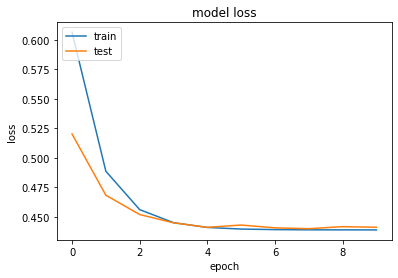

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Load in the original model from checkpoints and evaluate on the test data

In [ ]:
original_model = '/content/drive/MyDrive/266/original_model/goemo_model'

In [ ]:
model = build_model(base_layers.EVAL)

# Define metrics over each category.
metrics = []
for i, label in enumerate(LABELS):
  metric = tf.keras.metrics.Precision(
      thresholds=[0.5],
      class_id=i,
      name='precision@0.5/{}'.format(label))
  metrics.append(metric)
  metric = tf.keras.metrics.Recall(
      thresholds=[0.5],
      class_id=i,
      name='recall@0.5/{}'.format(label))
  metrics.append(metric)

# Define metrics over the entire task.
metric = tf.keras.metrics.Precision(thresholds=[0.5], name='precision@0.5/all')
metrics.append(metric)
metric = tf.keras.metrics.Recall(thresholds=[0.5], name='recall@0.5/all')
metrics.append(metric)

learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=CONFIG['learning_rate'],
    decay_rate=CONFIG['learning_rate_decay_rate'],
    decay_steps=CONFIG['learning_rate_decay_steps'],
    staircase=True)

loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

model.compile(metrics=metrics, loss=loss)

model.load_weights(original_model)

#results = model.evaluate(test_dataset, verbose = 1, steps = 1000)
#model.load_weights('model/model_checkpoint')
result = model.evaluate(x=test_dataset, return_dict=True)

3/3 [==============================] - 6s 37ms/step - loss: 0.4441 - precision@0.5/admiration: 0.1667 - recall@0.5/admiration: 0.1000 - precision@0.5/amusement: 0.0000e+00 - recall@0.5/amusement: 0.0000e+00 - precision@0.5/anger: 0.5000 - recall@0.5/anger: 0.3333 - precision@0.5/annoyance: 0.0000e+00 - recall@0.5/annoyance: 0.0000e+00 - precision@0.5/approval: 0.0000e+00 - recall@0.5/approval: 0.0000e+00 - precision@0.5/caring: 0.0000e+00 - recall@0.5/caring: 0.0000e+00 - precision@0.5/confusion: 0.0000e+00 - recall@0.5/confusion: 0.0000e+00 - precision@0.5/curiosity: 1.0000 - recall@0.5/curiosity: 0.2000 - precision@0.5/desire: 0.0000e+00 - recall@0.5/desire: 0.0000e+00 - precision@0.5/disappointment: 0.0000e+00 - recall@0.5/disappointment: 0.0000e+00 - precision@0.5/disapproval: 1.0000 - recall@0.5/disapproval: 0.0526 - precision@0.5/disgust: 0.0000e+00 - recall@0.5/disgust: 0.0000e+00 - precision@0.5/embarrassment: 0.0000e+00 - recall@0.5/embarrassment: 0.0000e+00 - precision@0.5/ex

Print evaluation metrics for the model, as well as per emotion label:

In [ ]:
for label in LABELS:
  precision_key = 'precision@0.5/{}'.format(label)
  recall_key = 'recall@0.5/{}'.format(label)
  if precision_key in result and recall_key in result:
    print('{}: (precision@0.5: {}, recall@0.5: {})'.format(
        label, result[precision_key], result[recall_key]))
    
precision_key = 'precision@0.5/all'
recall_key = 'recall@0.5/all'
if precision_key in result and recall_key in result:
  prec = result[precision_key]
  rec = result[recall_key]
  f1 = (2 * prec * rec) / (prec + rec)
  print('all: (precision@0.5: {}, recall@0.5: {}), f1-score'.format(
      result[precision_key], result[recall_key]), f1)

admiration: (precision@0.5: 0.1666666716337204, recall@0.5: 0.10000000149011612)
amusement: (precision@0.5: 0.0, recall@0.5: 0.0)
anger: (precision@0.5: 0.5, recall@0.5: 0.3333333432674408)
annoyance: (precision@0.5: 0.0, recall@0.5: 0.0)
approval: (precision@0.5: 0.0, recall@0.5: 0.0)
caring: (precision@0.5: 0.0, recall@0.5: 0.0)
confusion: (precision@0.5: 0.0, recall@0.5: 0.0)
curiosity: (precision@0.5: 1.0, recall@0.5: 0.20000000298023224)
desire: (precision@0.5: 0.0, recall@0.5: 0.0)
disappointment: (precision@0.5: 0.0, recall@0.5: 0.0)
disapproval: (precision@0.5: 1.0, recall@0.5: 0.05263157933950424)
disgust: (precision@0.5: 0.0, recall@0.5: 0.0)
embarrassment: (precision@0.5: 0.0, recall@0.5: 0.0)
excitement: (precision@0.5: 0.0, recall@0.5: 0.0)
fear: (precision@0.5: 0.0, recall@0.5: 0.0)
gratitude: (precision@0.5: 0.75, recall@0.5: 1.0)
grief: (precision@0.5: 0.0, recall@0.5: 0.0)
joy: (precision@0.5: 1.0, recall@0.5: 1.0)
love: (precision@0.5: 1.0, recall@0.5: 0.5)
nervousnes

Get prediction accuracy of baseline model rather than evaluation F1 score

In [ ]:
PREDICT_TEXT = [
  b'Good for you!',
  b'Happy birthday!',
  b'I love you.',
]

In [ ]:
model = build_model(base_layers.PREDICT)
model.load_weights(original_model)

for text in PREDICT_TEXT:
  results = model.predict(x=[text])
  print('')
  print('{}:'.format(text))
  labels = np.flip(np.argsort(results[0]))
  for x in range(3):
    label = LABELS[labels[x]]
    print('{}: {}'.format(label, results[0][labels[x]]))


b'Good for you!':
admiration: 0.836010217666626
caring: 0.43613725900650024
optimism: 0.4037437438964844

b'Happy birthday!':
excitement: 0.8367144465446472
joy: 0.8083208799362183
desire: 0.3934541642665863

b'I love you.':
love: 0.9999996423721313
nervousness: 0.9998273253440857
relief: 0.9997915029525757


Now we want to re-train our saved model on our Spotify tagged strings data. So we need to: 

1.   Load in the Spotify data, making any manipulations so that it's compatible with our existing model
2.   Build a shell model using build_model()
3.   Load_weights to get pretraining
4.   define optimizer and loss
5.   .compile
6.   .fit on spotify data
7.   Conduct fine-tuning - change adam parameter and freezing layers



This will build the spotify dataset to be ready for our model 

In [ ]:
from etils.epath.abstract_path import T
# Model training parameters.
CONFIG = {
    'name': 'models.prado',
    'batch_size': 53,
    'train_steps': 10000,
    'learning_rate': 0.0006,
    'learning_rate_decay_steps': 340,
    'learning_rate_decay_rate': 0.7,
}

CONFIG['save_checkpoints_steps'] = int(CONFIG['train_steps'] / 10)

MODEL_CONFIG = {
    'labels': LABELS,
    'multilabel': True,
    'quantize': False,
    'max_seq_len': 400,
    'max_seq_len_inference': 400,
    'exclude_nonalphaspace_unicodes': False,
    'split_on_space': True,
    'embedding_regularizer_scale': 0.035,
    'embedding_size': 64,
    'bigram_channels': 64,
    'trigram_channels': 64,
    'feature_size': 512,
    'network_regularizer_scale': 0.0001,
    'keep_prob': 0.5,
    'word_novelty_bits': 0,
    'doc_size_levels': 0,
    'add_bos_tag': False,
    'add_eos_tag': False,
    'pre_logits_fc_layers': [],
    'text_distortion_probability': 0.0,
}

CONFIG['model_config'] = MODEL_CONFIG

from layers import base_layers
from layers import projection_layers

def build_dataset(mode, inspect=False, dev = False):
  if mode == base_layers.TRAIN:
    split = 'train'
    count = None
  elif mode == base_layers.EVAL:
    split = 'test'
    count = 1
  else:
    raise ValueError('mode={}, must be TRAIN or EVAL'.format(mode))

  batch_size = CONFIG['batch_size']
  if inspect:
    batch_size = 1

  # Convert examples from their dataset format into the model format.
  def process_input(features):
    # Generate the projection for each comment_text input.  The final tensor 
    # will have the shape [batch_size, number of tokens, feature size].
    # Additionally, we generate a tensor containing the number of tokens for
    # each comment_text (seq_length).  This is needed because the projection
    # tensor is a full tensor, and we are not using EOS tokens.
    text = features['target_string']
    text = tf.reshape(text, [batch_size])
    projection_layer = projection_layers.ProjectionLayer(MODEL_CONFIG, mode)
    projection, seq_length = projection_layer(text)

    # Convert the labels into an indicator tensor, using the LABELS indices.
    label = tf.stack([features[label] for label in LABELS], axis=-1)
    label = tf.cast(label, tf.float32)
    label = tf.reshape(label, [batch_size, len(LABELS)])

    model_features = ({'projection': projection, 'sequence_length': seq_length}, label)

    if inspect:
      model_features = (model_features[0], model_features[1], features)

    return model_features
  if mode == base_layers.TRAIN:
    ds = sp_train
    ds = ds.repeat(count=count)
    ds = ds.shuffle(buffer_size=batch_size * 2)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.map(process_input, num_parallel_calls=tf.data.experimental.AUTOTUNE, deterministic=False)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  elif mode == base_layers.EVAL and dev == True:
    ds = sp_dev 
    ds = ds.shuffle(buffer_size=batch_size * 2)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.map(process_input, num_parallel_calls=tf.data.experimental.AUTOTUNE, deterministic=False)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE) 
  elif mode == base_layers.EVAL and dev == False:
    ds = sp_test
    ds = ds.shuffle(buffer_size=batch_size * 2)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.map(process_input, num_parallel_calls=tf.data.experimental.AUTOTUNE, deterministic=False)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  else:
    raise ValueError('mode={}, must be TRAIN or EVAL'.format(mode))
  
  return ds

train_dataset = build_dataset(base_layers.TRAIN)
test_dataset = build_dataset(base_layers.EVAL, dev = False)
val_dataset = build_dataset(base_layers.EVAL, dev = True)
inspect_dataset = build_dataset(base_layers.TRAIN, inspect=True)

First trial: Fine-tune all the layers without making any changes to the pretrained GoEmotions model

In [ ]:
# Remove any previous training data.
!rm -rf model

model = build_model(base_layers.TRAIN)

# Create the optimizer.
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=CONFIG['learning_rate'],
    decay_rate=CONFIG['learning_rate_decay_rate'],
    decay_steps=CONFIG['learning_rate_decay_steps'],
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Define the loss function.
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

model.compile(optimizer=optimizer, loss=loss, metrics = ['accuracy', custom_f1])

sp_filepath = '/content/drive/MyDrive/266/finetune_nochanges/nochanges'

model_checkpoint_callback = ModelCheckpoint(
    filepath = sp_filepath, 
    save_weights_only=True,
    verbose = 1)

model.load_weights(original_model)

epochs = int(CONFIG['train_steps'] / CONFIG['save_checkpoints_steps'])
history = model.fit(
    x=train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    steps_per_epoch=CONFIG['save_checkpoints_steps'],
    callbacks=[model_checkpoint_callback])

Epoch 1/10
 999/1000 [============================>.] - ETA: 0s - loss: 0.4894 - accuracy: 0.1494 - custom_f1: 0.1636
Epoch 1: saving model to /content/drive/MyDrive/266/finetune_nochanges/nochanges
1000/1000 [==============================] - 41s 30ms/step - loss: 0.4894 - accuracy: 0.1495 - custom_f1: 0.1636 - val_loss: 0.4900 - val_accuracy: 0.1698 - val_custom_f1: 0.1372
Epoch 2/10
 999/1000 [============================>.] - ETA: 0s - loss: 0.4895 - accuracy: 0.1501 - custom_f1: 0.1624
Epoch 2: saving model to /content/drive/MyDrive/266/finetune_nochanges/nochanges
1000/1000 [==============================] - 28s 28ms/step - loss: 0.4895 - accuracy: 0.1502 - custom_f1: 0.1625 - val_loss: 0.4845 - val_accuracy: 0.1761 - val_custom_f1: 0.1556
Epoch 3/10
 999/1000 [============================>.] - ETA: 0s - loss: 0.4896 - accuracy: 0.1499 - custom_f1: 0.1627
Epoch 3: saving model to /content/drive/MyDrive/266/finetune_nochanges/nochanges
1000/1000 [==============================] - 

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'custom_f1', 'val_loss', 'val_accuracy', 'val_custom_f1'])


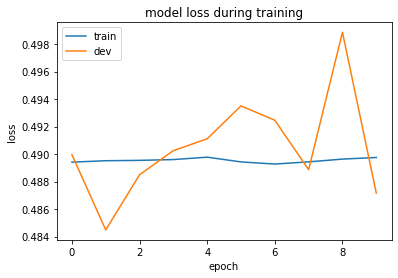

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss during training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

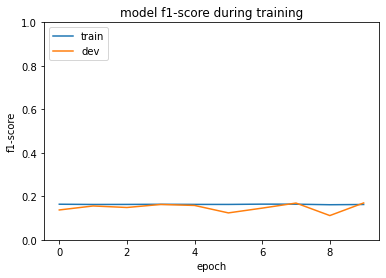

In [ ]:
plt.plot(history.history['custom_f1'])
plt.plot(history.history['val_custom_f1'])
plt.title('model f1-score during training')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [ ]:
model = build_model(base_layers.EVAL)

# Define metrics over each category.
metrics = []
for i, label in enumerate(LABELS):
  metric = tf.keras.metrics.Precision(
      thresholds=[0.5],
      class_id=i,
      name='precision@0.5/{}'.format(label))
  metrics.append(metric)
  metric = tf.keras.metrics.Recall(
      thresholds=[0.5],
      class_id=i,
      name='recall@0.5/{}'.format(label))
  metrics.append(metric)

# Define metrics over the entire task.
metric = tf.keras.metrics.Precision(thresholds=[0.5], name='precision@0.5/all')
metrics.append(metric)
metric = tf.keras.metrics.Recall(thresholds=[0.5], name='recall@0.5/all')
metrics.append(metric)
metric = custom_f1
metrics.append(metric)

model.compile(metrics=metrics)

model.load_weights(sp_filepath)

#results = model.evaluate(test_dataset, verbose = 1, steps = 1000)
#model.load_weights('model/model_checkpoint')
result = model.evaluate(x=test_dataset, return_dict=True)

3/3 [==============================] - 10s 69ms/step - loss: 0.0000e+00 - precision@0.5/admiration: 0.4000 - recall@0.5/admiration: 0.5714 - precision@0.5/amusement: 0.0312 - recall@0.5/amusement: 1.0000 - precision@0.5/anger: 0.0556 - recall@0.5/anger: 0.3333 - precision@0.5/annoyance: 0.2000 - recall@0.5/annoyance: 0.1250 - precision@0.5/approval: 0.2000 - recall@0.5/approval: 0.0625 - precision@0.5/caring: 0.0000e+00 - recall@0.5/caring: 0.0000e+00 - precision@0.5/confusion: 0.0000e+00 - recall@0.5/confusion: 0.0000e+00 - precision@0.5/curiosity: 0.4000 - recall@0.5/curiosity: 0.4444 - precision@0.5/desire: 0.0000e+00 - recall@0.5/desire: 0.0000e+00 - precision@0.5/disappointment: 0.1000 - recall@0.5/disappointment: 0.1250 - precision@0.5/disapproval: 0.4545 - recall@0.5/disapproval: 0.2381 - precision@0.5/disgust: 0.0000e+00 - recall@0.5/disgust: 0.0000e+00 - precision@0.5/embarrassment: 0.0000e+00 - recall@0.5/embarrassment: 0.0000e+00 - precision@0.5/excitement: 0.0000e+00 - reca

In [ ]:
for label in LABELS:
  precision_key = 'precision@0.5/{}'.format(label)
  recall_key = 'recall@0.5/{}'.format(label)
  if precision_key in result and recall_key in result:
    print('{}: (precision@0.5: {}, recall@0.5: {})'.format(
        label, result[precision_key], result[recall_key]))
    
precision_key = 'precision@0.5/all'
recall_key = 'recall@0.5/all'
if precision_key in result and recall_key in result:
  prec = result[precision_key]
  rec = result[recall_key]
  f1 = (2 * prec * rec) / (prec + rec)
  print('all: (precision@0.5: {}, recall@0.5: {}), f1-score'.format(
      result[precision_key], result[recall_key]), f1)

admiration: (precision@0.5: 0.4000000059604645, recall@0.5: 0.5714285969734192)
amusement: (precision@0.5: 0.03125, recall@0.5: 1.0)
anger: (precision@0.5: 0.0555555559694767, recall@0.5: 0.3333333432674408)
annoyance: (precision@0.5: 0.20000000298023224, recall@0.5: 0.125)
approval: (precision@0.5: 0.20000000298023224, recall@0.5: 0.0625)
caring: (precision@0.5: 0.0, recall@0.5: 0.0)
confusion: (precision@0.5: 0.0, recall@0.5: 0.0)
curiosity: (precision@0.5: 0.4000000059604645, recall@0.5: 0.4444444477558136)
desire: (precision@0.5: 0.0, recall@0.5: 0.0)
disappointment: (precision@0.5: 0.10000000149011612, recall@0.5: 0.125)
disapproval: (precision@0.5: 0.4545454680919647, recall@0.5: 0.2380952388048172)
disgust: (precision@0.5: 0.0, recall@0.5: 0.0)
embarrassment: (precision@0.5: 0.0, recall@0.5: 0.0)
excitement: (precision@0.5: 0.0, recall@0.5: 0.0)
fear: (precision@0.5: 0.0, recall@0.5: 0.0)
gratitude: (precision@0.5: 0.1304347813129425, recall@0.5: 1.0)
grief: (precision@0.5: 0.0,

Trial 2: Changing the learning rate 

In [ ]:
# Remove any previous training data.
!rm -rf model

model = build_model(base_layers.TRAIN)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

# Define the loss function.
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

model.compile(optimizer=optimizer, loss=loss, metrics = [tf.keras.metrics.BinaryAccuracy('accuracy'),
                                          tf.keras.metrics.Precision(),
                                          tf.keras.metrics.Recall(),
                                          custom_f1])

sp_filepath = '/content/drive/MyDrive/266/finetune_changelr/changelr'

model_checkpoint_callback = ModelCheckpoint(
    filepath = sp_filepath, 
    save_weights_only=True,
    verbose = 1)

model.load_weights(original_model)

epochs = int(CONFIG['train_steps'] / CONFIG['save_checkpoints_steps'])
history_2 = model.fit(
    x=train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    steps_per_epoch=CONFIG['save_checkpoints_steps'],
    callbacks=[model_checkpoint_callback])

Epoch 1/10
 999/1000 [============================>.] - ETA: 0s - loss: 0.4649 - accuracy: 0.8971 - precision: 0.1906 - recall: 0.3360 - custom_f1: 0.2475
Epoch 1: saving model to /content/drive/MyDrive/266/finetune_changelr/changelr
1000/1000 [==============================] - 33s 31ms/step - loss: 0.4649 - accuracy: 0.8971 - precision: 0.1906 - recall: 0.3361 - custom_f1: 0.2476 - val_loss: 0.4659 - val_accuracy: 0.8962 - val_precision: 0.1272 - val_recall: 0.2157 - val_custom_f1: 0.1700
Epoch 2/10
 999/1000 [============================>.] - ETA: 0s - loss: 0.4393 - accuracy: 0.9202 - precision: 0.2708 - recall: 0.3668 - custom_f1: 0.3148
Epoch 2: saving model to /content/drive/MyDrive/266/finetune_changelr/changelr
1000/1000 [==============================] - 29s 29ms/step - loss: 0.4393 - accuracy: 0.9202 - precision: 0.2707 - recall: 0.3668 - custom_f1: 0.3147 - val_loss: 0.4459 - val_accuracy: 0.9113 - val_precision: 0.1573 - val_recall: 0.2261 - val_custom_f1: 0.1861
Epoch 3/10

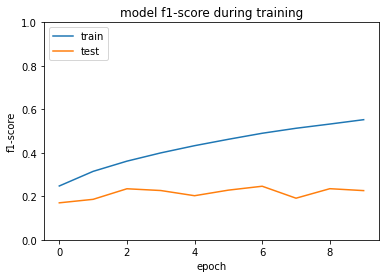

In [ ]:
plt.plot(history_2.history['custom_f1'])
plt.plot(history_2.history['val_custom_f1'])
plt.title('model f1-score during training')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

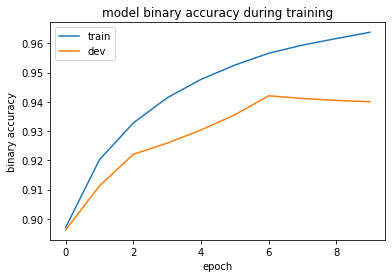

In [ ]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model binary accuracy during training')
plt.ylabel('binary accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [ ]:
sp_filepath = '/content/drive/MyDrive/266/finetune_changelr/changelr'

In [ ]:
model = build_model(base_layers.EVAL)

# Define metrics over each category.
metrics = []
for i, label in enumerate(LABELS):
  metric = tf.keras.metrics.Precision(
      thresholds=[0.5],
      class_id=i,
      name='precision@0.5/{}'.format(label))
  metrics.append(metric)
  metric = tf.keras.metrics.Recall(
      thresholds=[0.5],
      class_id=i,
      name='recall@0.5/{}'.format(label))
  metrics.append(metric)

# Define metrics over the entire task.
metric = tf.keras.metrics.Precision(thresholds=[0.5], name='precision@0.5/all')
metrics.append(metric)
metric = tf.keras.metrics.Recall(thresholds=[0.5], name='recall@0.5/all')
metrics.append(metric)
metric = custom_f1
metrics.append(metric)
metric = tf.keras.metrics.BinaryAccuracy('accuracy')
metrics.append(metric)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

model.compile(metrics=metrics, loss=loss)

model.load_weights(sp_filepath)

#results = model.evaluate(test_dataset, verbose = 1, steps = 1000)
#model.load_weights('model/model_checkpoint')
result = model.evaluate(x=test_dataset, return_dict=True)

3/3 [==============================] - 10s 39ms/step - loss: 0.3326 - precision@0.5/admiration: 0.6667 - recall@0.5/admiration: 0.1250 - precision@0.5/amusement: 0.3333 - recall@0.5/amusement: 1.0000 - precision@0.5/anger: 0.0000e+00 - recall@0.5/anger: 0.0000e+00 - precision@0.5/annoyance: 0.0000e+00 - recall@0.5/annoyance: 0.0000e+00 - precision@0.5/approval: 0.0000e+00 - recall@0.5/approval: 0.0000e+00 - precision@0.5/caring: 0.0000e+00 - recall@0.5/caring: 0.0000e+00 - precision@0.5/confusion: 0.5000 - recall@0.5/confusion: 0.3333 - precision@0.5/curiosity: 0.2500 - recall@0.5/curiosity: 0.1667 - precision@0.5/desire: 0.0000e+00 - recall@0.5/desire: 0.0000e+00 - precision@0.5/disappointment: 0.0000e+00 - recall@0.5/disappointment: 0.0000e+00 - precision@0.5/disapproval: 0.6000 - recall@0.5/disapproval: 0.1667 - precision@0.5/disgust: 0.0000e+00 - recall@0.5/disgust: 0.0000e+00 - precision@0.5/embarrassment: 0.0000e+00 - recall@0.5/embarrassment: 0.0000e+00 - precision@0.5/excitemen

In [ ]:
for label in LABELS:
  precision_key = 'precision@0.5/{}'.format(label)
  recall_key = 'recall@0.5/{}'.format(label)
  if precision_key in result and recall_key in result:
    print('{}: (precision@0.5: {}, recall@0.5: {})'.format(
        label, result[precision_key], result[recall_key]))
    
precision_key = 'precision@0.5/all'
recall_key = 'recall@0.5/all'
if precision_key in result and recall_key in result:
  prec = result[precision_key]
  rec = result[recall_key]
  f1 = (2 * prec * rec) / (prec + rec)
  print('all: (precision@0.5: {}, recall@0.5: {}), f1-score'.format(
      result[precision_key], result[recall_key]), f1)

admiration: (precision@0.5: 0.0, recall@0.5: 0.0)
amusement: (precision@0.5: 0.5, recall@0.5: 1.0)
anger: (precision@0.5: 1.0, recall@0.5: 0.3333333432674408)
annoyance: (precision@0.5: 0.0, recall@0.5: 0.0)
approval: (precision@0.5: 0.0, recall@0.5: 0.0)
caring: (precision@0.5: 0.0, recall@0.5: 0.0)
confusion: (precision@0.5: 0.5, recall@0.5: 0.20000000298023224)
curiosity: (precision@0.5: 0.4000000059604645, recall@0.5: 0.25)
desire: (precision@0.5: 0.0, recall@0.5: 0.0)
disappointment: (precision@0.5: 0.0, recall@0.5: 0.0)
disapproval: (precision@0.5: 0.5714285969734192, recall@0.5: 0.17391304671764374)
disgust: (precision@0.5: 0.0, recall@0.5: 0.0)
embarrassment: (precision@0.5: 0.0, recall@0.5: 0.0)
excitement: (precision@0.5: 0.0, recall@0.5: 0.0)
fear: (precision@0.5: 0.0, recall@0.5: 0.0)
gratitude: (precision@0.5: 0.75, recall@0.5: 1.0)
grief: (precision@0.5: 0.0, recall@0.5: 0.0)
joy: (precision@0.5: 0.0, recall@0.5: 0.0)
love: (precision@0.5: 0.0, recall@0.5: 0.0)
nervousnes

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import *
import sys
from pylab import *
import seaborn as sns

Freezing - Freeze all layers

In [ ]:
# Remove any previous training data.
!rm -rf model

model = build_model(base_layers.TRAIN)

# Create the optimizer.
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=CONFIG['learning_rate'],
    decay_rate=CONFIG['learning_rate_decay_rate'],
    decay_steps=CONFIG['learning_rate_decay_steps'],
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Define the loss function.
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

model.compile(optimizer=optimizer, loss=loss, metrics = [tf.keras.metrics.BinaryAccuracy('accuracy'),
                                          tf.keras.metrics.Precision(),
                                          tf.keras.metrics.Recall(),
                                          custom_f1])

fl_filepath = '/content/drive/MyDrive/266/freezing/all'

model_checkpoint_callback = ModelCheckpoint(
    filepath = fl_filepath, 
    save_weights_only=True,
    verbose = 1)

model.load_weights(original_model)

model.trainable = False

epochs = int(CONFIG['train_steps'] / CONFIG['save_checkpoints_steps'])
model.fit(
    x=train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    steps_per_epoch=CONFIG['save_checkpoints_steps'],
    callbacks=[model_checkpoint_callback])

Epoch 1/10
1000/1000 [==============================] - ETA: 0s - loss: 0.4835 - accuracy: 0.8842 - precision_1: 0.1305 - recall_1: 0.2390 - custom_f1: 0.1710
Epoch 1: saving model to /content/drive/MyDrive/266/freezing/all
1000/1000 [==============================] - 48s 46ms/step - loss: 0.4835 - accuracy: 0.8842 - precision_1: 0.1305 - recall_1: 0.2390 - custom_f1: 0.1710 - val_loss: 0.4867 - val_accuracy: 0.8704 - val_precision_1: 0.1171 - val_recall_1: 0.2612 - val_custom_f1: 0.1617
Epoch 2/10
1000/1000 [==============================] - ETA: 0s - loss: 0.4835 - accuracy: 0.8840 - precision_1: 0.1307 - recall_1: 0.2402 - custom_f1: 0.1710
Epoch 2: saving model to /content/drive/MyDrive/266/freezing/all
1000/1000 [==============================] - 45s 45ms/step - loss: 0.4835 - accuracy: 0.8840 - precision_1: 0.1307 - recall_1: 0.2402 - custom_f1: 0.1710 - val_loss: 0.4856 - val_accuracy: 0.9079 - val_precision_1: 0.1526 - val_recall_1: 0.2302 - val_custom_f1: 0.1835
Epoch 3/10
 99

In [ ]:
model = build_model(base_layers.EVAL)

# Define metrics over each category.
metrics = []
for i, label in enumerate(LABELS):
  metric = tf.keras.metrics.Precision(
      thresholds=[0.5],
      class_id=i,
      name='precision@0.5/{}'.format(label))
  metrics.append(metric)
  metric = tf.keras.metrics.Recall(
      thresholds=[0.5],
      class_id=i,
      name='recall@0.5/{}'.format(label))
  metrics.append(metric)

# Define metrics over the entire task.
metric = tf.keras.metrics.Precision(thresholds=[0.5], name='precision@0.5/all')
metrics.append(metric)
metric = tf.keras.metrics.Recall(thresholds=[0.5], name='recall@0.5/all')
metrics.append(metric)

model.compile(metrics=metrics)

model.load_weights(fl_filepath)

#results = model.evaluate(test_dataset, verbose = 1, steps = 1000)
#model.load_weights('model/model_checkpoint')
result = model.evaluate(x=test_dataset, return_dict=True)

1/1 [==============================] - 6s 6s/step - loss: 0.0000e+00 - precision@0.5/admiration: 0.2857 - recall@0.5/admiration: 0.1538 - precision@0.5/amusement: 0.0667 - recall@0.5/amusement: 1.0000 - precision@0.5/anger: 0.0000e+00 - recall@0.5/anger: 0.0000e+00 - precision@0.5/annoyance: 0.0000e+00 - recall@0.5/annoyance: 0.0000e+00 - precision@0.5/approval: 0.5000 - recall@0.5/approval: 0.0909 - precision@0.5/caring: 0.0000e+00 - recall@0.5/caring: 0.0000e+00 - precision@0.5/confusion: 0.0000e+00 - recall@0.5/confusion: 0.0000e+00 - precision@0.5/curiosity: 0.3750 - recall@0.5/curiosity: 0.7500 - precision@0.5/desire: 0.0000e+00 - recall@0.5/desire: 0.0000e+00 - precision@0.5/disappointment: 0.0000e+00 - recall@0.5/disappointment: 0.0000e+00 - precision@0.5/disapproval: 0.1429 - recall@0.5/disapproval: 0.0667 - precision@0.5/disgust: 0.0000e+00 - recall@0.5/disgust: 0.0000e+00 - precision@0.5/embarrassment: 0.0000e+00 - recall@0.5/embarrassment: 0.0000e+00 - precision@0.5/exciteme

In [ ]:
for label in LABELS:
  precision_key = 'precision@0.5/{}'.format(label)
  recall_key = 'recall@0.5/{}'.format(label)
  if precision_key in result and recall_key in result:
    print('{}: (precision@0.5: {}, recall@0.5: {})'.format(
        label, result[precision_key], result[recall_key]))
    
precision_key = 'precision@0.5/all'
recall_key = 'recall@0.5/all'
if precision_key in result and recall_key in result:
  prec = result[precision_key]
  rec = result[recall_key]
  f1 = (2 * prec * rec) / (prec + rec)
  print('all: (precision@0.5: {}, recall@0.5: {}), f1-score'.format(
      result[precision_key], result[recall_key]), f1)

admiration: (precision@0.5: 0.2857142984867096, recall@0.5: 0.1538461595773697)
amusement: (precision@0.5: 0.06666667014360428, recall@0.5: 1.0)
anger: (precision@0.5: 0.0, recall@0.5: 0.0)
annoyance: (precision@0.5: 0.0, recall@0.5: 0.0)
approval: (precision@0.5: 0.5, recall@0.5: 0.09090909361839294)
caring: (precision@0.5: 0.0, recall@0.5: 0.0)
confusion: (precision@0.5: 0.0, recall@0.5: 0.0)
curiosity: (precision@0.5: 0.375, recall@0.5: 0.75)
desire: (precision@0.5: 0.0, recall@0.5: 0.0)
disappointment: (precision@0.5: 0.0, recall@0.5: 0.0)
disapproval: (precision@0.5: 0.1428571492433548, recall@0.5: 0.06666667014360428)
disgust: (precision@0.5: 0.0, recall@0.5: 0.0)
embarrassment: (precision@0.5: 0.0, recall@0.5: 0.0)
excitement: (precision@0.5: 0.0, recall@0.5: 0.0)
fear: (precision@0.5: 0.0, recall@0.5: 0.0)
gratitude: (precision@0.5: 0.6666666865348816, recall@0.5: 1.0)
grief: (precision@0.5: 0.0, recall@0.5: 0.0)
joy: (precision@0.5: 0.0, recall@0.5: 0.0)
love: (precision@0.5: 

Try just freezing the first layer

In [ ]:
!rm -rf model

model = build_model(base_layers.TRAIN)

# Create the optimizer.
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=CONFIG['learning_rate'],
    decay_rate=CONFIG['learning_rate_decay_rate'],
    decay_steps=CONFIG['learning_rate_decay_steps'],
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Define the loss function.
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

model.compile(optimizer=optimizer, loss=loss, metrics = [tf.keras.metrics.BinaryAccuracy('accuracy'),
                                          tf.keras.metrics.Precision(),
                                          tf.keras.metrics.Recall(),
                                          custom_f1])

fl_filepath = '/content/drive/MyDrive/266/freeze_one/one'

model_checkpoint_callback = ModelCheckpoint(
    filepath = fl_filepath, 
    save_weights_only=True,
    verbose = 1)

model.load_weights(original_model)

model.layers[3].trainable = False

assert model.layers[3].trainable_weights == []

In [ ]:
epochs = int(CONFIG['train_steps'] / CONFIG['save_checkpoints_steps'])
history_f1 = model.fit(
    x=train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    steps_per_epoch=CONFIG['save_checkpoints_steps'],
    callbacks=[model_checkpoint_callback])

Epoch 1/10
1000/1000 [==============================] - ETA: 0s - loss: 0.4835 - accuracy: 0.8839 - precision_3: 0.1310 - recall_3: 0.2412 - custom_f1: 0.1719
Epoch 1: saving model to /content/drive/MyDrive/266/freeze_one/one
1000/1000 [==============================] - 48s 45ms/step - loss: 0.4835 - accuracy: 0.8839 - precision_3: 0.1310 - recall_3: 0.2412 - custom_f1: 0.1719 - val_loss: 0.4790 - val_accuracy: 0.8811 - val_precision_3: 0.1282 - val_recall_3: 0.2692 - val_custom_f1: 0.1737
Epoch 2/10
1000/1000 [==============================] - ETA: 0s - loss: 0.4836 - accuracy: 0.8835 - precision_3: 0.1303 - recall_3: 0.2411 - custom_f1: 0.1712
Epoch 2: saving model to /content/drive/MyDrive/266/freeze_one/one
1000/1000 [==============================] - 44s 44ms/step - loss: 0.4836 - accuracy: 0.8835 - precision_3: 0.1303 - recall_3: 0.2411 - custom_f1: 0.1712 - val_loss: 0.4802 - val_accuracy: 0.8689 - val_precision_3: 0.1071 - val_recall_3: 0.2640 - val_custom_f1: 0.1524
Epoch 3/10

In [ ]:
model = build_model(base_layers.EVAL)

# Define metrics over each category.
metrics = []
for i, label in enumerate(LABELS):
  metric = tf.keras.metrics.Precision(
      thresholds=[0.5],
      class_id=i,
      name='precision@0.5/{}'.format(label))
  metrics.append(metric)
  metric = tf.keras.metrics.Recall(
      thresholds=[0.5],
      class_id=i,
      name='recall@0.5/{}'.format(label))
  metrics.append(metric)

# Define metrics over the entire task.
metric = tf.keras.metrics.Precision(thresholds=[0.5], name='precision@0.5/all')
metrics.append(metric)
metric = tf.keras.metrics.Recall(thresholds=[0.5], name='recall@0.5/all')
metrics.append(metric)

model.compile(metrics=metrics)

model.load_weights(fl_filepath)

#results = model.evaluate(test_dataset, verbose = 1, steps = 1000)
#model.load_weights('model/model_checkpoint')
result = model.evaluate(x=test_dataset, return_dict=True)

1/1 [==============================] - 5s 5s/step - loss: 0.0000e+00 - precision@0.5/admiration: 0.3750 - recall@0.5/admiration: 0.3333 - precision@0.5/amusement: 1.0000 - recall@0.5/amusement: 1.0000 - precision@0.5/anger: 1.0000 - recall@0.5/anger: 0.3333 - precision@0.5/annoyance: 0.2500 - recall@0.5/annoyance: 0.1667 - precision@0.5/approval: 0.5000 - recall@0.5/approval: 0.1111 - precision@0.5/caring: 0.0000e+00 - recall@0.5/caring: 0.0000e+00 - precision@0.5/confusion: 0.2000 - recall@0.5/confusion: 0.3333 - precision@0.5/curiosity: 0.3333 - recall@0.5/curiosity: 0.2500 - precision@0.5/desire: 0.0000e+00 - recall@0.5/desire: 0.0000e+00 - precision@0.5/disappointment: 0.0000e+00 - recall@0.5/disappointment: 0.0000e+00 - precision@0.5/disapproval: 0.4444 - recall@0.5/disapproval: 0.2857 - precision@0.5/disgust: 0.0000e+00 - recall@0.5/disgust: 0.0000e+00 - precision@0.5/embarrassment: 0.0000e+00 - recall@0.5/embarrassment: 0.0000e+00 - precision@0.5/excitement: 0.0000e+00 - recall@

In [ ]:
for label in LABELS:
  precision_key = 'precision@0.5/{}'.format(label)
  recall_key = 'recall@0.5/{}'.format(label)
  if precision_key in result and recall_key in result:
    print('{}: (precision@0.5: {}, recall@0.5: {})'.format(
        label, result[precision_key], result[recall_key]))
    
precision_key = 'precision@0.5/all'
recall_key = 'recall@0.5/all'
if precision_key in result and recall_key in result:
  prec = result[precision_key]
  rec = result[recall_key]
  f1 = (2 * prec * rec) / (prec + rec)
  print('all: (precision@0.5: {}, recall@0.5: {}), f1-score'.format(
      result[precision_key], result[recall_key]), f1)

admiration: (precision@0.5: 0.375, recall@0.5: 0.3333333432674408)
amusement: (precision@0.5: 1.0, recall@0.5: 1.0)
anger: (precision@0.5: 1.0, recall@0.5: 0.3333333432674408)
annoyance: (precision@0.5: 0.25, recall@0.5: 0.1666666716337204)
approval: (precision@0.5: 0.5, recall@0.5: 0.1111111119389534)
caring: (precision@0.5: 0.0, recall@0.5: 0.0)
confusion: (precision@0.5: 0.20000000298023224, recall@0.5: 0.3333333432674408)
curiosity: (precision@0.5: 0.3333333432674408, recall@0.5: 0.25)
desire: (precision@0.5: 0.0, recall@0.5: 0.0)
disappointment: (precision@0.5: 0.0, recall@0.5: 0.0)
disapproval: (precision@0.5: 0.4444444477558136, recall@0.5: 0.2857142984867096)
disgust: (precision@0.5: 0.0, recall@0.5: 0.0)
embarrassment: (precision@0.5: 0.0, recall@0.5: 0.0)
excitement: (precision@0.5: 0.0, recall@0.5: 0.0)
fear: (precision@0.5: 0.0, recall@0.5: 0.0)
gratitude: (precision@0.5: 0.5, recall@0.5: 1.0)
grief: (precision@0.5: 0.0, recall@0.5: 0.0)
joy: (precision@0.5: 0.0, recall@0.5

## Try changing some other hyperparameters on completely fine tuned model


# Binary CrossEntropy -> Categorical CrossEntropy



In [ ]:
# Model training parameters.
CONFIG = {
    'name': 'models.prado',
    'batch_size': 100,
    'train_steps': 10000,
    'learning_rate': 0.0006,
    'learning_rate_decay_steps': 340,
    'learning_rate_decay_rate': 0.7,
}

CONFIG['save_checkpoints_steps'] = int(CONFIG['train_steps'] / 10)

MODEL_CONFIG = {
    'labels': LABELS,
    'multilabel': True,
    'quantize': False,
    'max_seq_len': 400,
    'max_seq_len_inference': 400,
    'exclude_nonalphaspace_unicodes': False,
    'split_on_space': True,
    'embedding_regularizer_scale': 0.035,
    'embedding_size': 64,
    'bigram_channels': 64,
    'trigram_channels': 64,
    'feature_size': 512,
    'network_regularizer_scale': 0.0001,
    'keep_prob': 0.5,
    'word_novelty_bits': 0,
    'doc_size_levels': 0,
    'add_bos_tag': False,
    'add_eos_tag': False,
    'pre_logits_fc_layers': [],
    'text_distortion_probability': 0.0,
}

CONFIG['model_config'] = MODEL_CONFIG

from layers import base_layers
from layers import projection_layers

def build_dataset(mode, inspect=False):
  if mode == base_layers.TRAIN:
    split = 'train'
    count = None
  elif mode == base_layers.EVAL:
    split = 'test'
    count = 1
  else:
    raise ValueError('mode={}, must be TRAIN or EVAL'.format(mode))

  batch_size = CONFIG['batch_size']
  if inspect:
    batch_size = 1

  # Convert examples from their dataset format into the model format.
  def process_input(features):
    # Generate the projection for each comment_text input.  The final tensor 
    # will have the shape [batch_size, number of tokens, feature size].
    # Additionally, we generate a tensor containing the number of tokens for
    # each comment_text (seq_length).  This is needed because the projection
    # tensor is a full tensor, and we are not using EOS tokens.
    text = features['target_string']
    text = tf.reshape(text, [batch_size])
    projection_layer = projection_layers.ProjectionLayer(MODEL_CONFIG, mode)
    projection, seq_length = projection_layer(text)

    # Convert the labels into an indicator tensor, using the LABELS indices.
    label = tf.stack([features[label] for label in LABELS], axis=-1)
    label = tf.cast(label, tf.float32)
    label = tf.reshape(label, [batch_size, len(LABELS)])

    model_features = ({'projection': projection, 'sequence_length': seq_length}, label)

    if inspect:
      model_features = (model_features[0], model_features[1], features)

    return model_features

  ds = sp_train
  ds = ds.repeat(count=count)
  ds = ds.shuffle(buffer_size=batch_size * 2)
  ds = ds.batch(batch_size, drop_remainder=True)
  ds = ds.map(process_input, num_parallel_calls=tf.data.experimental.AUTOTUNE, deterministic=False)
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

train_dataset = build_dataset(base_layers.TRAIN)
test_dataset = build_dataset(base_layers.EVAL)
inspect_dataset = build_dataset(base_layers.TRAIN, inspect=True)

In [ ]:
# Remove any previous training data.
!rm -rf model

model = build_model(base_layers.TRAIN)

# Create the optimizer.
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=CONFIG['learning_rate'],
    decay_rate=CONFIG['learning_rate_decay_rate'],
    decay_steps=CONFIG['learning_rate_decay_steps'],
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

# !!Changing the loss function from BinaryCrossEntropy to CrossEntropy!!
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

model.compile(optimizer=optimizer, loss=loss)

sp_filepath = '/content/drive/MyDrive/266/finetune_goemo/goemo_model/fine_tune_sp_2'

model_checkpoint_callback = ModelCheckpoint(
    filepath = sp_filepath, 
    save_weights_only=True,
    verbose = 1)

model.load_weights(original_model)

epochs = int(CONFIG['train_steps'] / CONFIG['save_checkpoints_steps'])
model.fit(
    x=train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    steps_per_epoch=CONFIG['save_checkpoints_steps'],
    callbacks=[model_checkpoint_callback])

Epoch 1/10
 999/1000 [============================>.] - ETA: 0s - loss: 4.0952
Epoch 1: saving model to /content/drive/MyDrive/266/finetune_goemo/goemo_model/fine_tune_sp_2
1000/1000 [==============================] - 50s 48ms/step - loss: 4.0953 - val_loss: 3.8247
Epoch 2/10
 999/1000 [============================>.] - ETA: 0s - loss: 3.6707
Epoch 2: saving model to /content/drive/MyDrive/266/finetune_goemo/goemo_model/fine_tune_sp_2
1000/1000 [==============================] - 48s 48ms/step - loss: 3.6707 - val_loss: 3.5345
Epoch 3/10
1000/1000 [==============================] - ETA: 0s - loss: 3.4026
Epoch 3: saving model to /content/drive/MyDrive/266/finetune_goemo/goemo_model/fine_tune_sp_2
1000/1000 [==============================] - 48s 48ms/step - loss: 3.4026 - val_loss: 3.2880
Epoch 4/10
 999/1000 [============================>.] - ETA: 0s - loss: 3.1836
Epoch 4: saving model to /content/drive/MyDrive/266/finetune_goemo/goemo_model/fine_tune_sp_2
1000/1000 [==================

In [ ]:
model = build_model(base_layers.EVAL)

# Define metrics over each category.
metrics = []
for i, label in enumerate(LABELS):
  metric = tf.keras.metrics.Precision(
      thresholds=[0.5],
      class_id=i,
      name='precision@0.5/{}'.format(label))
  metrics.append(metric)
  metric = tf.keras.metrics.Recall(
      thresholds=[0.5],
      class_id=i,
      name='recall@0.5/{}'.format(label))
  metrics.append(metric)

# Define metrics over the entire task.
metric = tf.keras.metrics.Precision(thresholds=[0.5], name='precision@0.5/all')
metrics.append(metric)
metric = tf.keras.metrics.Recall(thresholds=[0.5], name='recall@0.5/all')
metrics.append(metric)

model.compile(metrics=metrics)

model.load_weights(sp_filepath)

#results = model.evaluate(test_dataset, verbose = 1, steps = 1000)
#model.load_weights('model/model_checkpoint')
result = model.evaluate(x=test_dataset, return_dict=True)

16/16 [==============================] - 7s 54ms/step - loss: 0.0000e+00 - precision@0.5/admiration: 0.5904 - recall@0.5/admiration: 1.0000 - precision@0.5/amusement: 0.1852 - recall@0.5/amusement: 0.9524 - precision@0.5/anger: 0.4154 - recall@0.5/anger: 0.8438 - precision@0.5/annoyance: 0.4386 - recall@0.5/annoyance: 0.9804 - precision@0.5/approval: 0.4649 - recall@0.5/approval: 1.0000 - precision@0.5/caring: 0.2119 - recall@0.5/caring: 0.9615 - precision@0.5/confusion: 0.2136 - recall@0.5/confusion: 0.9844 - precision@0.5/curiosity: 0.3569 - recall@0.5/curiosity: 0.9915 - precision@0.5/desire: 0.3008 - recall@0.5/desire: 1.0000 - precision@0.5/disappointment: 0.3569 - recall@0.5/disappointment: 0.9915 - precision@0.5/disapproval: 0.6463 - recall@0.5/disapproval: 0.9805 - precision@0.5/disgust: 0.2500 - recall@0.5/disgust: 1.0000 - precision@0.5/embarrassment: 0.0385 - recall@0.5/embarrassment: 0.2500 - precision@0.5/excitement: 0.2927 - recall@0.5/excitement: 0.9730 - precision@0.5/f

In [ ]:
for label in LABELS:
  precision_key = 'precision@0.5/{}'.format(label)
  recall_key = 'recall@0.5/{}'.format(label)
  if precision_key in result and recall_key in result:
    print('{}: (precision@0.5: {}, recall@0.5: {})'.format(
        label, result[precision_key], result[recall_key]))
    
precision_key = 'precision@0.5/all'
recall_key = 'recall@0.5/all'
if precision_key in result and recall_key in result:
  prec = result[precision_key]
  rec = result[recall_key]
  f1 = (2 * prec * rec) / (prec + rec)
  print('all: (precision@0.5: {}, recall@0.5: {}), f1-score'.format(
      result[precision_key], result[recall_key]), f1)

admiration: (precision@0.5: 0.5904058814048767, recall@0.5: 1.0)
amusement: (precision@0.5: 0.18518517911434174, recall@0.5: 0.9523809552192688)
anger: (precision@0.5: 0.4153846204280853, recall@0.5: 0.84375)
annoyance: (precision@0.5: 0.4385964870452881, recall@0.5: 0.9803921580314636)
approval: (precision@0.5: 0.4648910462856293, recall@0.5: 1.0)
caring: (precision@0.5: 0.2118644118309021, recall@0.5: 0.9615384340286255)
confusion: (precision@0.5: 0.2135593146085739, recall@0.5: 0.984375)
curiosity: (precision@0.5: 0.35692307353019714, recall@0.5: 0.9914529919624329)
desire: (precision@0.5: 0.3008130192756653, recall@0.5: 1.0)
disappointment: (precision@0.5: 0.35692307353019714, recall@0.5: 0.9914529919624329)
disapproval: (precision@0.5: 0.6463022232055664, recall@0.5: 0.9804878234863281)
disgust: (precision@0.5: 0.25, recall@0.5: 1.0)
embarrassment: (precision@0.5: 0.03846153989434242, recall@0.5: 0.25)
excitement: (precision@0.5: 0.2926829159259796, recall@0.5: 0.9729729890823364)

# Model Config


In [ ]:
# Model training parameters.
CONFIG = {
    'name': 'models.prado',
    'batch_size': 700,
    'train_steps': 10000,
    'learning_rate': 0.0006,
    'learning_rate_decay_steps': 340,
    'learning_rate_decay_rate': 0.7,
}

CONFIG['save_checkpoints_steps'] = int(CONFIG['train_steps'] / 10)

MODEL_CONFIG = {
    'labels': LABELS,
    'multilabel': True,
    'quantize': False,
    'max_seq_len': 400,
    'max_seq_len_inference': 400,
    'exclude_nonalphaspace_unicodes': False,
    'split_on_space': True,
    'embedding_regularizer_scale': 0.035,
    'embedding_size': 64,
    'bigram_channels': 64,
    'trigram_channels': 64,
    'feature_size': 512,
    'network_regularizer_scale': 0.0001,
    'keep_prob': 0.5,
    'word_novelty_bits': 0,
    'doc_size_levels': 0,
    'add_bos_tag': False,
    'add_eos_tag': False,
    'pre_logits_fc_layers': [],
    'text_distortion_probability': 0.0,
}

CONFIG['model_config'] = MODEL_CONFIG

from layers import base_layers
from layers import projection_layers

def build_dataset(mode, inspect=False):
  if mode == base_layers.TRAIN:
    split = 'train'
    count = None
  elif mode == base_layers.EVAL:
    split = 'test'
    count = 1
  else:
    raise ValueError('mode={}, must be TRAIN or EVAL'.format(mode))

  batch_size = CONFIG['batch_size']
  if inspect:
    batch_size = 1

  # Convert examples from their dataset format into the model format.
  def process_input(features):
    # Generate the projection for each comment_text input.  The final tensor 
    # will have the shape [batch_size, number of tokens, feature size].
    # Additionally, we generate a tensor containing the number of tokens for
    # each comment_text (seq_length).  This is needed because the projection
    # tensor is a full tensor, and we are not using EOS tokens.
    text = features['target_string']
    text = tf.reshape(text, [batch_size])
    projection_layer = projection_layers.ProjectionLayer(MODEL_CONFIG, mode)
    projection, seq_length = projection_layer(text)

    # Convert the labels into an indicator tensor, using the LABELS indices.
    label = tf.stack([features[label] for label in LABELS], axis=-1)
    label = tf.cast(label, tf.float32)
    label = tf.reshape(label, [batch_size, len(LABELS)])

    model_features = ({'projection': projection, 'sequence_length': seq_length}, label)

    if inspect:
      model_features = (model_features[0], model_features[1], features)

    return model_features

  ds = sp_train
  ds = ds.repeat(count=count)
  ds = ds.shuffle(buffer_size=batch_size * 2)
  ds = ds.batch(batch_size, drop_remainder=True)
  ds = ds.map(process_input, num_parallel_calls=tf.data.experimental.AUTOTUNE, deterministic=False)
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

train_dataset = build_dataset(base_layers.TRAIN)
test_dataset = build_dataset(base_layers.EVAL)
inspect_dataset = build_dataset(base_layers.TRAIN, inspect=True)

In [ ]:
# Remove any previous training data.
!rm -rf model

model = build_model(base_layers.TRAIN)

# Create the optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

# !!Changing the loss function from BinaryCrossEntropy to CrossEntropy!!
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

model.compile(optimizer=optimizer, loss=loss, metrics = ['accuracy', custom_f1])

sp_filepath = '/content/drive/MyDrive/266/finetune_goemo/fine_tune_best'

model_checkpoint_callback = ModelCheckpoint(
    filepath = sp_filepath, 
    save_weights_only=True,
    verbose = 1)

model.load_weights(original_model)

epochs = int(CONFIG['train_steps'] / CONFIG['save_checkpoints_steps'])
model.fit(
    x=train_dataset,
    epochs= epochs,
    validation_data=test_dataset,
    steps_per_epoch=CONFIG['save_checkpoints_steps'],
    callbacks=[model_checkpoint_callback])

Epoch 1/10
1000/1000 [==============================] - ETA: 0s - loss: 0.4442 - accuracy: 0.3382 - custom_f1: 0.3384
Epoch 1: saving model to /content/drive/MyDrive/266/finetune_goemo/fine_tune_best
1000/1000 [==============================] - 278s 266ms/step - loss: 0.4442 - accuracy: 0.3382 - custom_f1: 0.3384 - val_loss: 0.4277 - val_accuracy: 0.4057 - val_custom_f1: 0.4296
Epoch 2/10
1000/1000 [==============================] - ETA: 0s - loss: 0.4166 - accuracy: 0.4702 - custom_f1: 0.4839
Epoch 2: saving model to /content/drive/MyDrive/266/finetune_goemo/fine_tune_best
1000/1000 [==============================] - 265s 265ms/step - loss: 0.4166 - accuracy: 0.4702 - custom_f1: 0.4839 - val_loss: 0.4041 - val_accuracy: 0.5343 - val_custom_f1: 0.5415
Epoch 3/10
1000/1000 [==============================] - ETA: 0s - loss: 0.3943 - accuracy: 0.5611 - custom_f1: 0.5730
Epoch 3: saving model to /content/drive/MyDrive/266/finetune_goemo/fine_tune_best
1000/1000 [===========================

In [ ]:
sp_filepath = '/content/drive/MyDrive/266/finetune_goemo/fine_tune_best'

In [ ]:
model = build_model(base_layers.EVAL)

# Define metrics over each category.
metrics = []
for i, label in enumerate(LABELS):
  metric = tf.keras.metrics.Precision(
      thresholds=[0.5],
      class_id=i,
      name='precision@0.5/{}'.format(label))
  metrics.append(metric)
  metric = tf.keras.metrics.Recall(
      thresholds=[0.5],
      class_id=i,
      name='recall@0.5/{}'.format(label))
  metrics.append(metric)

# Define metrics over the entire task.
metric = tf.keras.metrics.Precision(thresholds=[0.5], name='precision@0.5/all')
metrics.append(metric)
metric = tf.keras.metrics.Recall(thresholds=[0.5], name='recall@0.5/all')
metrics.append(metric)
metric = custom_f1
metrics.append(metric)

model.compile(metrics=metrics)

model.load_weights(sp_filepath)

#results = model.evaluate(test_dataset, verbose = 1, steps = 1000)
#model.load_weights('model/model_checkpoint')
result = model.evaluate(x=test_dataset, return_dict=True)

2/2 [==============================] - 10s 193ms/step - loss: 0.0000e+00 - precision@0.5/admiration: 1.0000 - recall@0.5/admiration: 0.9925 - precision@0.5/amusement: 1.0000 - recall@0.5/amusement: 0.8000 - precision@0.5/anger: 1.0000 - recall@0.5/anger: 0.8696 - precision@0.5/annoyance: 1.0000 - recall@0.5/annoyance: 0.6667 - precision@0.5/approval: 1.0000 - recall@0.5/approval: 0.9405 - precision@0.5/caring: 1.0000 - recall@0.5/caring: 0.2105 - precision@0.5/confusion: 1.0000 - recall@0.5/confusion: 0.8214 - precision@0.5/curiosity: 0.9900 - recall@0.5/curiosity: 0.9429 - precision@0.5/desire: 0.9286 - recall@0.5/desire: 0.8387 - precision@0.5/disappointment: 1.0000 - recall@0.5/disappointment: 0.9712 - precision@0.5/disapproval: 1.0000 - recall@0.5/disapproval: 0.9551 - precision@0.5/disgust: 1.0000 - recall@0.5/disgust: 0.1818 - precision@0.5/embarrassment: 0.0000e+00 - recall@0.5/embarrassment: 0.0000e+00 - precision@0.5/excitement: 1.0000 - recall@0.5/excitement: 0.5938 - precisi

In [ ]:
for label in LABELS:
  precision_key = 'precision@0.5/{}'.format(label)
  recall_key = 'recall@0.5/{}'.format(label)
  if precision_key in result and recall_key in result:
    print('{}: (precision@0.5: {}, recall@0.5: {})'.format(
        label, result[precision_key], result[recall_key]))
    
precision_key = 'precision@0.5/all'
recall_key = 'recall@0.5/all'
if precision_key in result and recall_key in result:
  prec = result[precision_key]
  rec = result[recall_key]
  f1 = (2 * prec * rec) / (prec + rec)
  print('all: (precision@0.5: {}, recall@0.5: {}), f1-score'.format(
      result[precision_key], result[recall_key]), f1)

admiration: (precision@0.5: 1.0, recall@0.5: 0.9925373196601868)
amusement: (precision@0.5: 1.0, recall@0.5: 0.800000011920929)
anger: (precision@0.5: 1.0, recall@0.5: 0.8695651888847351)
annoyance: (precision@0.5: 1.0, recall@0.5: 0.6666666865348816)
approval: (precision@0.5: 1.0, recall@0.5: 0.9404761791229248)
caring: (precision@0.5: 1.0, recall@0.5: 0.21052631735801697)
confusion: (precision@0.5: 1.0, recall@0.5: 0.8214285969734192)
curiosity: (precision@0.5: 0.9900000095367432, recall@0.5: 0.9428571462631226)
desire: (precision@0.5: 0.9285714030265808, recall@0.5: 0.8387096524238586)
disappointment: (precision@0.5: 1.0, recall@0.5: 0.9711538553237915)
disapproval: (precision@0.5: 1.0, recall@0.5: 0.9550561904907227)
disgust: (precision@0.5: 1.0, recall@0.5: 0.1818181872367859)
embarrassment: (precision@0.5: 0.0, recall@0.5: 0.0)
excitement: (precision@0.5: 1.0, recall@0.5: 0.59375)
fear: (precision@0.5: 1.0, recall@0.5: 0.5116279125213623)
gratitude: (precision@0.5: 0.973684191703

In [ ]:
import pandas as pd

In [ ]:
batch_df = pd.DataFrame()
batch_df['batch_size'] = [32, 100, 300, 400, 500, 700]
batch_df['f1_score'] = [.58, .73, .87, .89, .912, .929]

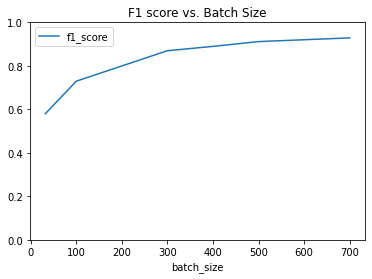

In [ ]:
batch_df.plot(x='batch_size', y= 'f1_score', title = 'F1 score vs. Batch Size', ylim = [0,1])